In [1]:
import numpy as np 
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
from sklearn.model_selection import StratifiedKFold
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.optim.lr_scheduler import ReduceLROnPlateau,CosineAnnealingLR
from matplotlib import pyplot as plt
import cv2
import timm
import torch.nn.functional as F
import seaborn as sns

sns.set_palette('Set2')

In [2]:
class CFG:
    img_size = 256
    model = 'resnet34'
    folds = 5
    seed = 42
    n_classes = 5
    weight_decay = 0.1 # for adamw
    l2_penalty = 0.01 # for RMSprop
    rms_momentum = 0 # for RMSprop
    LEARNING_RATE = 1e-3
    pretrained = True
    optimizer = 'adam'
    scheduler = 'CosineAnnealingLR'
    plateau_factor = 0.5
    plateau_patience = 3
    cosine_T_max = 4
    cosine_eta_min = 1e-8
    verbose = True
    BATCH_SIZE = 32
    probability = 0.6
    trn_folds = [0]
    debug = False
    N_EPOCHS = 20
    shuffle = False
    

In [3]:
df = pd.read_csv('/kaggle/input/cassava-leaf-disease-classification/train.csv')
test_df = df.tail(1000)
df = df.head(5000)

if CFG.debug:
    df = df.head(100).copy()

In [4]:
df['label'].hist()

<Axes: >

In [5]:
df

image_id  label
0     1000015157.jpg      0
1     1000201771.jpg      3
2      100042118.jpg      1
3     1000723321.jpg      1
4     1000812911.jpg      3
...              ...    ...
4995  1891755915.jpg      4
4996  1891912456.jpg      2
4997  1891937724.jpg      3
4998  1892079469.jpg      3
4999  1892210616.jpg      3

[5000 rows x 2 columns]

In [6]:
def index_to_path(idx):
    return '/kaggle/input/cassava-leaf-disease-classification/train_images/'+idx

df['path'] = df['image_id'].apply(index_to_path)
test_df['path'] = test_df['image_id'].apply(index_to_path)

In [7]:
skf = StratifiedKFold(n_splits=CFG.folds,random_state=CFG.seed,shuffle=True)

df['fold'] = -1
for fold, (trn_indx,val_indx) in enumerate(skf.split(df['path'],y=df['label'])):
    df.loc[val_indx,'fold'] = fold

<Axes: >

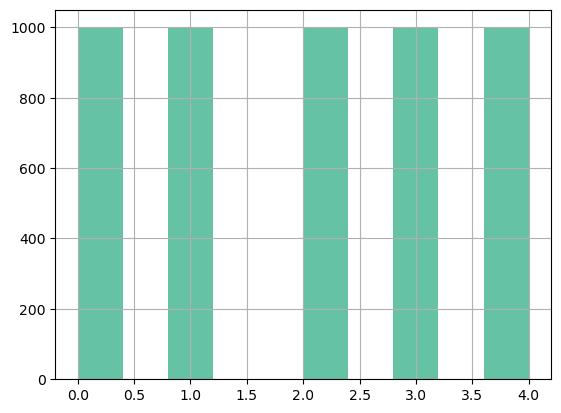

In [8]:
df['fold'].hist()

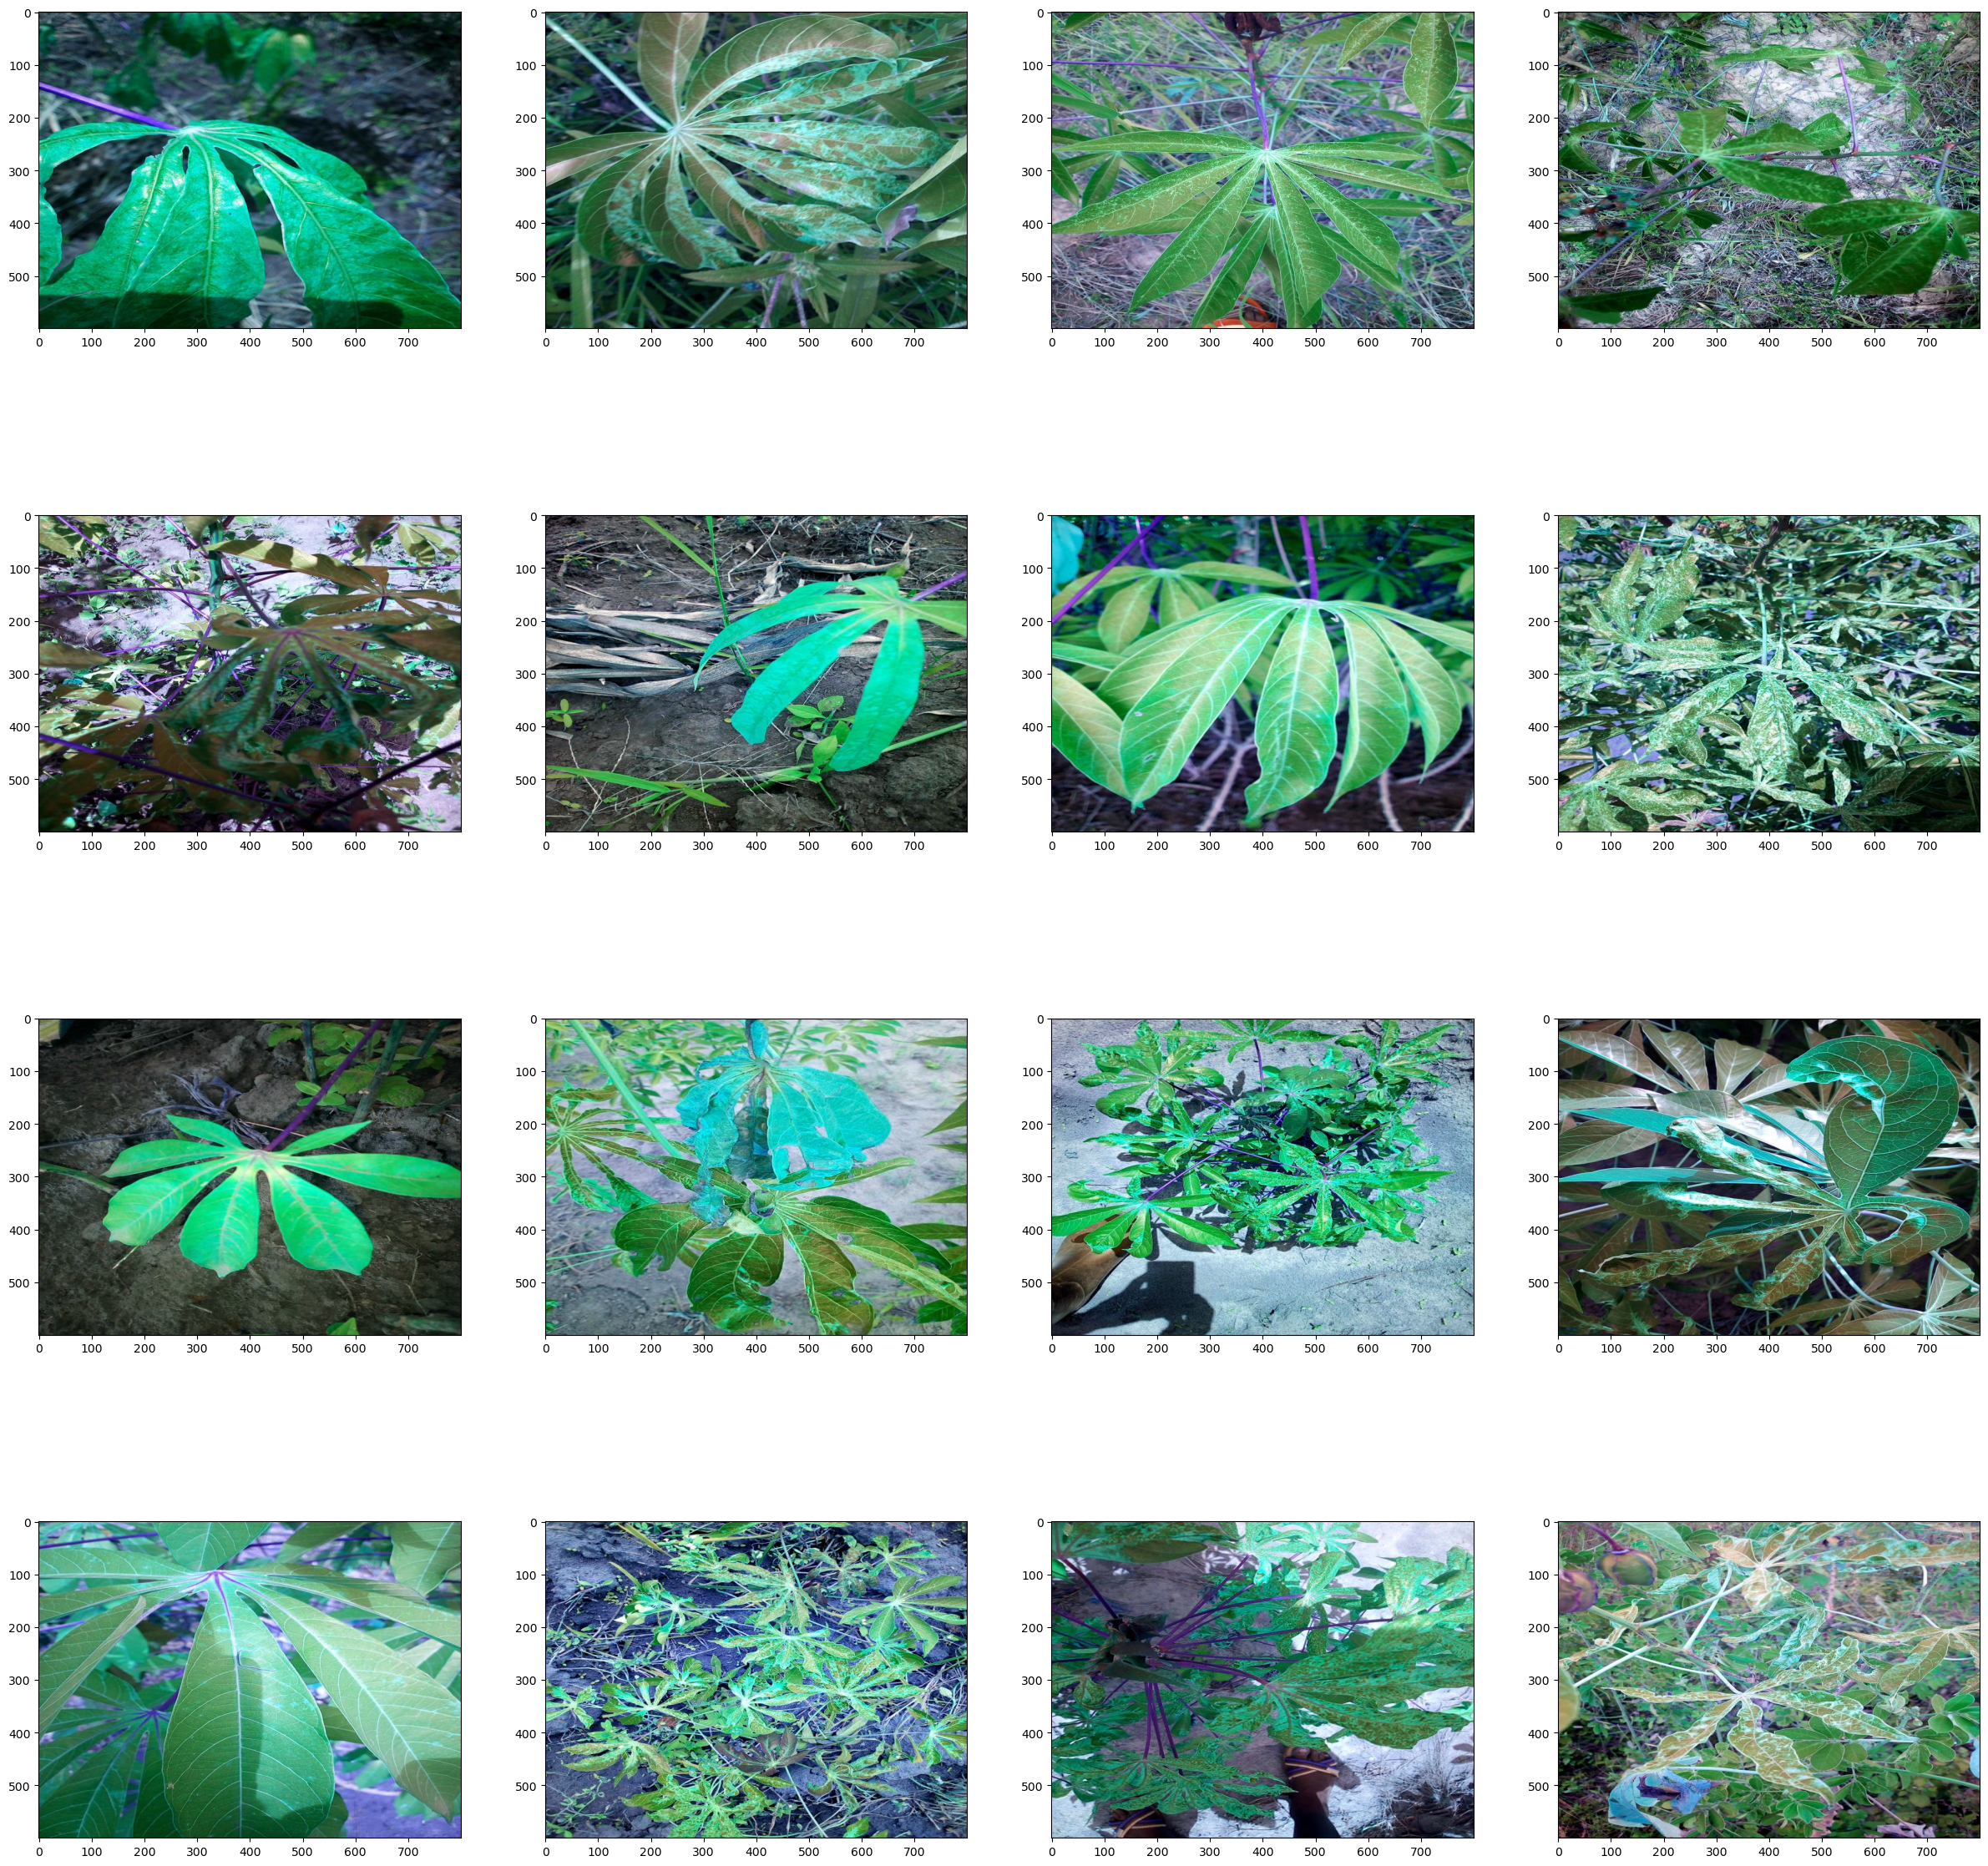

In [9]:
imgs_paths = df['path'].sample(16)
_,axes = plt.subplots(4,4,figsize=(30,30))
for i in range(4):
    for j in range(4):
        img = cv2.imread(imgs_paths.iloc[i*4 + j])
        axes[i,j].imshow(img)
plt.show()

In [10]:
train_transform = A.Compose(
    [
        A.CenterCrop(height=CFG.img_size, width=CFG.img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
    [
        A.CenterCrop(height=CFG.img_size, width=CFG.img_size),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [11]:
class LeafDiseaseDataset(Dataset):
    def __init__(self,df,is_train=True,train_transform=None,test_transform=None):
        self.df = df
        self.is_train = is_train
        self.train_transform = train_transform
        self.test_transform = test_transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        img_path = self.df['path'].iloc[idx]
        img = cv2.imread(img_path)
        
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.is_train:
            if self.train_transform is not None:
                img = self.train_transform(image=img)['image']
            label = self.df['label'].iloc[idx]
            
            return img, label
        
        if self.test_transform is not None:
            img = self.test_transform(image=img)['image']
        
        return img

In [12]:
class PlantModel(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.cnn = timm.create_model(CFG.model,pretrained=CFG.pretrained,num_classes=CFG.n_classes)        
        
    def forward(self,inputs):
        out = self.cnn(inputs)
        return out

In [13]:
def get_optimizer(lr = CFG.LEARNING_RATE):
    if CFG.optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay = CFG.weight_decay, amsgrad = False)

    elif CFG.optimizer == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(), lr = lr, weight_decay = CFG.weight_decay)

    elif CFG.optimizer == 'rmsprop':
        optimizer = torch.optim.RMSprop(model.parameters(), lr = lr, weight_decay = CFG.l2_penalty, momentum = CFG.rms_momentum)

    else:
        print('Optimizer is not defined')
    return optimizer
        

In [14]:
def get_scheduler(optimizer):

    if CFG.scheduler=='ReduceLROnPlateau': 
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor = CFG.plateau_factor, patience = CFG.plateau_patience, verbose = CFG.verbose)

    elif CFG.scheduler=='CosineAnnealingLR':
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = CFG.cosine_T_max, eta_min = CFG.cosine_eta_min)

    else:
        print('LR Scheduler is not defined')

    return scheduler

In [15]:
def train_fn(train_loader, model, criterion, optmizer, device):
    
  # switch to train mode
    model.train()
    
    
    size = len(train_loader.dataset)
    num_batches = len(train_loader)

    loss, correct = 0, 0

  ################################# train #################################

    for batch, (X, y) in enumerate(train_loader):
        
        device = torch.device(device)
        X, y = X.to(device), y.to(device)  

    # compute predictions and loss
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, y.long().squeeze()) 
        current = batch * len(X)

    # Backpropagation: only in train function, not done in validation function
        loss.backward()
        optimizer.step()

    # sum correct predictions
        y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
        correct += (y_pred == y_true).type(torch.float).sum().item()

    # log
        loss, current = np.round(loss.item(), 5), batch * len(X)
  
    correct /= size 
    loss /= num_batches # epoch loss

    print(f"Train: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

    return loss, correct

In [16]:
def valid_fn(valid_loader, model, criterion, device):
    model.eval()

    size = len(valid_loader.dataset)
    num_batches = len(valid_loader)

    loss, correct = 0, 0
    preds = np.array([]).reshape(0,1)

  ################################# validation #################################

    with torch.no_grad():
        for batch, (X, y) in enumerate(valid_loader):

            device = torch.device(device)
            X, y = X.to(device), y.to(device)

      # compute predictions and loss
            pred = model(X)
            loss = criterion(pred, y.long().squeeze()) 
            current = batch * len(X)
      
      # sum correct predictions
            y_pred, y_true = torch.argmax(pred, axis=1), y.long().squeeze()
            preds = np.vstack((preds,y_pred.cpu().reshape(-1,1)))
            correct += (y_pred == y_true).type(torch.float).sum().item()
      
      # log
            loss, current = np.round(loss.item(), 5), batch * len(X)
    correct /= size # epoch accuracy
    loss /= num_batches # epoch loss

    print(f"Valid: Accuracy: {(100*correct):>0.2f}%, Avg loss: {loss:>5f} \n")

    return loss, correct, preds

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [19]:
for fold in CFG.trn_folds:
    loss_fn = FocalLoss()

    # instantiate model
    device = torch.device(device)
    model = PlantModel().to(device) # move the model to GPU before constructing optimizers for it

    print('\n ******************************* Using backbone: ', CFG.model,f'training {fold} fold', " ******************************* \n")

    optimizer = get_optimizer(lr = CFG.LEARNING_RATE)

    scheduler = get_scheduler(optimizer)
    
    
    train_df = df[df['fold'] !=fold].copy()
    valid_df = df[df['fold'] ==fold].copy()

    train_dataset = LeafDiseaseDataset(train_df,is_train=True,train_transform=train_transform) # data augmentation. set augmentations = None to disable augmentations
    valid_dataset = LeafDiseaseDataset(valid_df,is_train=True,train_transform=test_transform) # data augmentation. set augmentations = None to disable augmentations

    train_dataloader = DataLoader(train_dataset,
                                  batch_size = CFG.BATCH_SIZE,
                                  shuffle = CFG.shuffle)

    valid_dataloader = DataLoader(valid_dataset,
                                  batch_size = CFG.BATCH_SIZE,
                                  shuffle = CFG.shuffle)


    train_loss_history = []
    train_acc_history = []
    valid_loss_history = []
    valid_acc_history = []
    LR_history = []

    best_loss = np.inf
    best_epoch_loss = 0
    best_acc = 0
    best_epoch_acc = 0

    print('Starting Training...\n')


    for epoch in tqdm(range(CFG.N_EPOCHS)):
        print(f"\n-------------------------------   Epoch {epoch + 1}   -------------------------------\n")
      # train
        train_loss, train_acc = train_fn(train_dataloader, model, loss_fn, optimizer, device)
        train_loss_history.append(train_loss)
        train_acc_history.append(train_acc)

      # validation
        valid_loss, valid_acc,y_pred = valid_fn(valid_dataloader, model, loss_fn, device)
        valid_loss_history.append(valid_loss)
        valid_acc_history.append(valid_acc)

      # apply LR scheduler after each epoch
        if isinstance(scheduler, ReduceLROnPlateau):   
            scheduler.step(valid_loss)

        elif isinstance(scheduler, CosineAnnealingLR):
            scheduler.step()

      # save LR value to plot later
        for param_group in optimizer.param_groups:    
            LR_history.append(param_group['lr'])

        if valid_loss < best_loss:
            best_epoch_loss = epoch + 1
            best_loss = valid_loss

        if valid_acc > best_acc:
            best_epoch_acc = epoch + 1
            best_acc = valid_acc
            torch.save(model.state_dict(), '/kaggle/working/' + f"{fold}_model.pth")    

            prediction = y_pred
            
    oof = pd.DataFrame({'image_id':valid_df['image_id'].values,
                           'label':valid_df['label'].values,
                           'pred':prediction.reshape(-1)})        
    oof.to_csv(f'oof_{fold}.csv',index=False)
            


    print("Done!")


 ******************************* Using backbone:  resnet34 training 0 fold  ******************************* 

Starting Training...



  0%|          | 0/20 [00:00<?, ?it/s]


-------------------------------   Epoch 1   -------------------------------

Train: Accuracy: 61.95%, Avg loss: 0.004186 



  5%|▌         | 1/20 [01:46<33:37, 106.20s/it]

Valid: Accuracy: 63.80%, Avg loss: 0.007471 


-------------------------------   Epoch 2   -------------------------------

Train: Accuracy: 64.72%, Avg loss: 0.003628 



 10%|█         | 2/20 [02:51<24:42, 82.36s/it] 

Valid: Accuracy: 66.60%, Avg loss: 0.006067 


-------------------------------   Epoch 3   -------------------------------

Train: Accuracy: 66.30%, Avg loss: 0.003347 



 15%|█▌        | 3/20 [03:57<21:09, 74.65s/it]

Valid: Accuracy: 66.10%, Avg loss: 0.005542 


-------------------------------   Epoch 4   -------------------------------

Train: Accuracy: 66.62%, Avg loss: 0.003140 

Valid: Accuracy: 67.30%, Avg loss: 0.005141 



 20%|██        | 4/20 [05:03<18:58, 71.14s/it]


-------------------------------   Epoch 5   -------------------------------

Train: Accuracy: 67.53%, Avg loss: 0.002955 



 25%|██▌       | 5/20 [06:08<17:15, 69.04s/it]

Valid: Accuracy: 67.30%, Avg loss: 0.004900 


-------------------------------   Epoch 6   -------------------------------

Train: Accuracy: 66.97%, Avg loss: 0.003023 



 30%|███       | 6/20 [07:13<15:45, 67.55s/it]

Valid: Accuracy: 68.60%, Avg loss: 0.005480 


-------------------------------   Epoch 7   -------------------------------

Train: Accuracy: 66.17%, Avg loss: 0.003156 



 35%|███▌      | 7/20 [08:18<14:28, 66.85s/it]

Valid: Accuracy: 66.20%, Avg loss: 0.004562 


-------------------------------   Epoch 8   -------------------------------

Train: Accuracy: 64.80%, Avg loss: 0.003785 



 40%|████      | 8/20 [09:24<13:17, 66.49s/it]

Valid: Accuracy: 63.40%, Avg loss: 0.008235 


-------------------------------   Epoch 9   -------------------------------

Train: Accuracy: 63.55%, Avg loss: 0.003741 



 45%|████▌     | 9/20 [10:29<12:08, 66.23s/it]

Valid: Accuracy: 62.40%, Avg loss: 0.011009 


-------------------------------   Epoch 10   -------------------------------

Train: Accuracy: 63.60%, Avg loss: 0.003902 



 50%|█████     | 10/20 [11:35<10:59, 65.99s/it]

Valid: Accuracy: 62.40%, Avg loss: 0.014578 


-------------------------------   Epoch 11   -------------------------------

Train: Accuracy: 63.90%, Avg loss: 0.003838 



 55%|█████▌    | 11/20 [12:41<09:53, 65.91s/it]

Valid: Accuracy: 63.90%, Avg loss: 0.008337 


-------------------------------   Epoch 12   -------------------------------

Train: Accuracy: 65.15%, Avg loss: 0.003148 



 60%|██████    | 12/20 [13:46<08:47, 65.88s/it]

Valid: Accuracy: 65.20%, Avg loss: 0.008409 


-------------------------------   Epoch 13   -------------------------------

Train: Accuracy: 66.15%, Avg loss: 0.002942 



 65%|██████▌   | 13/20 [14:52<07:40, 65.75s/it]

Valid: Accuracy: 65.40%, Avg loss: 0.006281 


-------------------------------   Epoch 14   -------------------------------

Train: Accuracy: 65.75%, Avg loss: 0.002937 



 70%|███████   | 14/20 [15:57<06:33, 65.60s/it]

Valid: Accuracy: 65.60%, Avg loss: 0.019685 


-------------------------------   Epoch 15   -------------------------------

Train: Accuracy: 63.58%, Avg loss: 0.003624 



 75%|███████▌  | 15/20 [17:02<05:27, 65.41s/it]

Valid: Accuracy: 62.40%, Avg loss: 0.014454 


-------------------------------   Epoch 16   -------------------------------

Train: Accuracy: 63.00%, Avg loss: 0.004844 



 80%|████████  | 16/20 [18:07<04:21, 65.42s/it]

Valid: Accuracy: 60.60%, Avg loss: 0.005782 


-------------------------------   Epoch 17   -------------------------------

Train: Accuracy: 62.50%, Avg loss: 0.004430 



 85%|████████▌ | 17/20 [19:14<03:16, 65.64s/it]

Valid: Accuracy: 62.40%, Avg loss: 0.012269 


-------------------------------   Epoch 18   -------------------------------

Train: Accuracy: 62.72%, Avg loss: 0.004095 



 90%|█████████ | 18/20 [20:19<02:11, 65.69s/it]

Valid: Accuracy: 62.60%, Avg loss: 0.010408 


-------------------------------   Epoch 19   -------------------------------

Train: Accuracy: 62.50%, Avg loss: 0.003999 



 95%|█████████▌| 19/20 [21:26<01:05, 65.99s/it]

Valid: Accuracy: 62.10%, Avg loss: 0.015406 


-------------------------------   Epoch 20   -------------------------------

Train: Accuracy: 63.38%, Avg loss: 0.003082 



100%|██████████| 20/20 [22:36<00:00, 67.82s/it]

Valid: Accuracy: 63.50%, Avg loss: 0.007358 

Done!


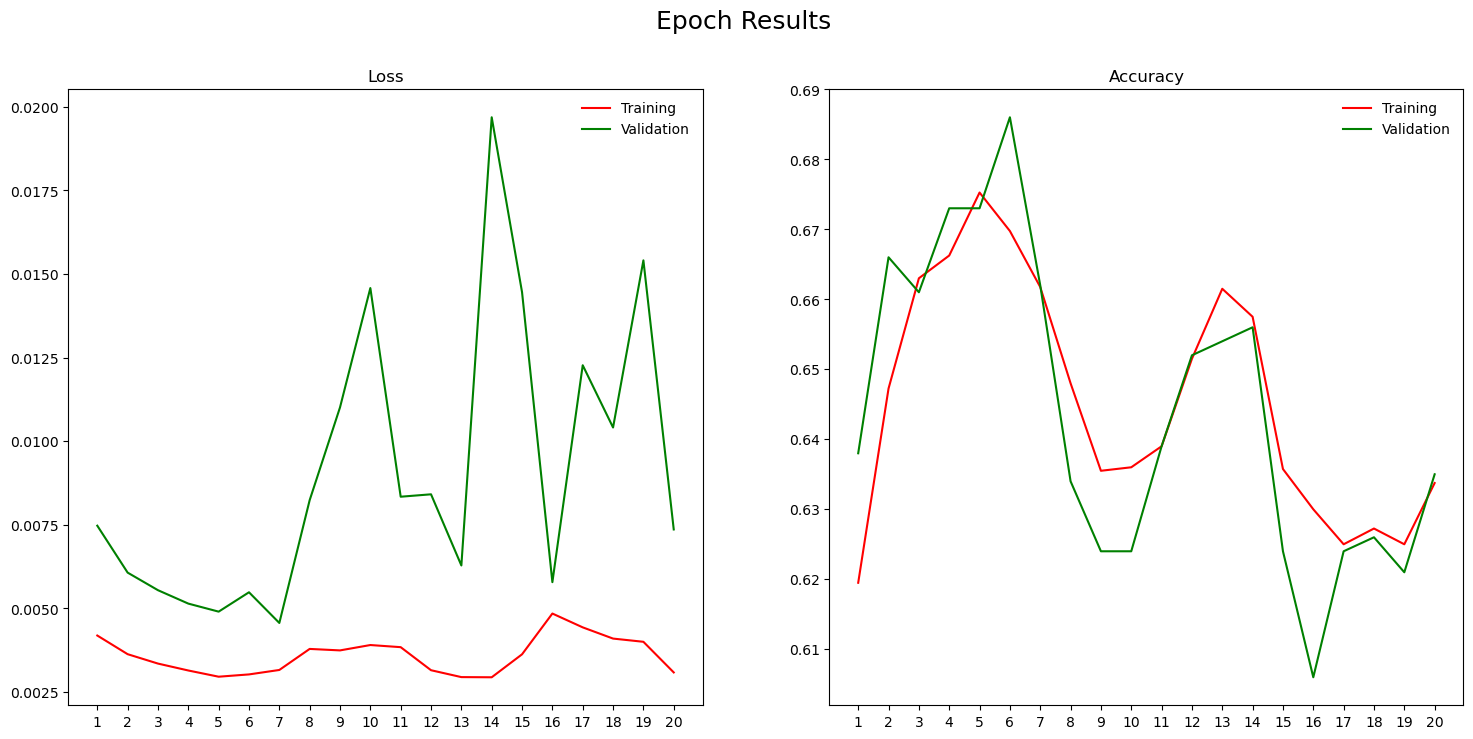

In [20]:
fig = plt.figure(figsize = (18, 8))
fig.suptitle('Epoch Results', fontsize = 18)

abscissa = np.arange(1, CFG.N_EPOCHS + 1, 1)

if CFG.N_EPOCHS <= 20:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, 1)
else:
  x_ticks = np.arange(1, CFG.N_EPOCHS + 1, int(CFG.N_EPOCHS/20) + 1)

# Loss plot
ax1 = plt.subplot(1, 2, 1)
ax1.plot(abscissa, train_loss_history, label='Training', color = 'red')
ax1.plot(abscissa, valid_loss_history, label='Validation', color = 'green')
plt.xticks(x_ticks)
plt.title("Loss")
ax1.legend(frameon=False);

# Accuracy plot
ax2 = plt.subplot(1, 2, 2)
ax2.plot(abscissa, train_acc_history, label='Training', color = 'red')
ax2.plot(abscissa, valid_acc_history, label='Validation', color = 'green')
plt.xticks(x_ticks)
plt.title("Accuracy")
ax2.legend(frameon=False);

In [21]:
test_dataset = LeafDiseaseDataset(test_df,is_train=False,train_transform=test_transform,test_transform=test_transform)
test_loader = DataLoader(test_dataset,batch_size=CFG.BATCH_SIZE,drop_last=False)

In [22]:
def softmax(x):
    return np.exp(x)/np.sum(np.exp(x), axis=1)[:, None]

def inference(test_loader,fold):
    
    #model.eval()

    predictions = []

    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    

    model = PlantModel().to(device)

    model.load_state_dict(torch.load(f'/kaggle/working/{fold}_model.pth'))

    # disable gradients for inference
    with torch.no_grad():

        for batch, X in enumerate(test_loader):


        ################################# inference #################################
            X = X.to(device)

        # compute predictions
            pred = model(X)       
        # softmax
            y_pred = softmax(pred.detach().cpu().numpy()) # convert tensor to numpy and apply softmax 
            #y_pred = np.argmax(y_pred, axis = 1) # take the indice of the max value (higher probability: predicted class)

        # store results
            predictions.append(y_pred)

    test_predictions = np.concatenate(predictions, axis = 0) # join sequence of arrays along axis 0
    return test_predictions

In [23]:
predictions = np.zeros((len(test_df),5))
for fold in CFG.trn_folds:
    test_predictions = inference(test_loader,fold)
    predictions += test_predictions
predictions =predictions/len(CFG.trn_folds)
predictions = np.argmax(predictions, axis = 1)

In [24]:
test_df['preds'] = predictions
test_df.to_csv('test_preds_exp01.csv',index=False)